# Learning disentangled representations

x --> encoder --> z [-1, 1] --> sample --> z' {-1, 1} --> dropout --> z'' {-1, 0, 1} --> decoder --> x_bar

z' ~ Binomial(p = |z| * 0.5 + 0.5).sample() * 2 - 1

The idea is that z either recognizes excitatorily (z == 1) or inhibitorily (z == -1) or z is ambiguous/ignorable/not-applicable (z near 0).

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap

from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
plt.style.use('classic')
plt_cm_RdYlGn_colors=['#FF8080', '#000000', '#80FF80']
plt_cm_RdYlGn_=LinearSegmentedColormap.from_list('plt_cm_RdYlGn_', plt_cm_RdYlGn_colors)


# from google.colab import drive
# drive.mount('/content/gdrive')
# save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/QDL_01'

In [0]:
def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader


def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4), cmap=plt.cm.plasma):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=cmap)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  assert images.shape[0] == nrows * ncols, f"{images.shape[0]} != {nrows} * {ncols}"

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, var, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == var.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  pdfs = []
  for i in np.arange(mu_combined.shape[0]):
    pdf = norm.pdf(rr, mu_combined[i], var_combined[i])
    pdf = pdf / pdf.sum()
    pdfs.append(pdf)
  
  mu__ = torch.as_tensor(pdfs)
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)
  
  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  #mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  #print("to_pdf: mu__", mu__.shape)
  
  return mu__

# plt.plot(to_pdf(torch.tensor([[[[0.49]]]]), torch.tensor([[[[0.04]]]]), resolution=40).reshape(-1, 1).numpy())

def sample_from_pdf(pdf):
    assert pdf.shape == (resolution, )
    #print("pdf ", pdf)

    sum_pdf = sum(pdf)
    #print("sum_pdf ", sum_pdf)

    if sum_pdf > 0:
        v = random.random()
        #print("v ", v)

        s = 0
        index = 0
        while s < v and index < resolution:
          s += pdf[index] / sum_pdf
          index += 1
          #print("  s ", s)
          #print("  index ", index)
          
        # apply scale (conflates value and confidence!)
        return [(index - 1) * sum_pdf / resolution]
    else:
        return [0]


def sample_from_images__(images__):
    assert len(images__.shape) == 3

    # reshape images__ from (image count, height, width*resolution) into (image count*height*width, resolution)
    s = images__.shape
    flattened_images__ = images__.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = flattened_images__.shape
    flattened_images__ = flattened_images__.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (image count*height*width, 1)
    sampled_pixels = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in flattened_images__])

    # reshape back into (image count, height, width)
    sampled_images = sampled_pixels.view(s[0], s[1], s[2])

    return sampled_images


def averaged_sample_from_images__(images__, count=10):
    sampled_images = torch.stack([sample_from_images__(images__) for i in range(count)])
    return sampled_images.mean(dim=0)

## Train
Use x values in the range 0-1

In [0]:
# x -> QD(x) -> x_bar
# Quantized distribution auto encoder
class QDAE(nn.Module):
  def __init__(self, input_output_size, hidden_size, latent_feature_count, resolution):
    super(QDAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.input_output_size = input_output_size
    self.hidden_size = hidden_size
    self.latent_feature_count = latent_feature_count
    self.resolution = resolution

    self.enc1 = nn.Linear(input_output_size,  hidden_size*8)
    self.enc2 = nn.Linear(hidden_size*8, hidden_size*4)
    self.enc3 = nn.Linear(hidden_size*4, hidden_size)
    self.enc4 = nn.Linear(hidden_size, latent_feature_count * resolution)
    
    #assert latent_feature_count == 1, "TODO: 1 qd_to_features layer per latent feature"
    #self.qd_to_features = nn.Linear(latent_feature_count * resolution, latent_feature_count)
    
    self.dec1 = nn.Linear(latent_feature_count * resolution, hidden_size * 4)
    self.dec2 = nn.Linear(hidden_size * 4, input_output_size)
    
    self.monotonic = torch.sigmoid(torch.linspace(0, 1, self.resolution)).unsqueeze(dim=1)
    self.dropout = nn.Dropout(0.2)

  def encode(self, x):
    x = self.dropout(x)

    x = self.enc1(x)
    x = F.relu(x)

    x = self.enc2(x)
    x = F.relu(x)

    x = self.enc3(x)
    x = F.relu(x)

    x = self.enc4(x)
    x = torch.tanh(x)
    return x
    
  def decode(self, z__):
    y = self.dec1(z__)
    y = F.relu(y)
    y = self.dec2(y)
    #x_bar = F.sigmoid(y)
    x_bar = y
    return x_bar
    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    z = self.encode(x)
    z_ = self.reparameterize(z)
    z__ = self.dropout(z_)
    z__ = z_
    
    x_bar = self.decode(z__)
    return z, z_, z__, x_bar
  
  def reparameterize(self, z):
    z_ = torch.distributions.relaxed_bernoulli.RelaxedBernoulli(0.1, z * 0.5 + 0.5).rsample() * 2 - 1
    #z_ = torch.bernoulli(z * 0.5 + 0.5) * 2 - 1
    #z_ = z
    return z_
  
def train(model, device, data, optimizer, epochs, log_interval):
  model.train()
  #print("X", X)
  for epoch in range(epochs):
    for i, d in enumerate(data, 0):
      if i > 10:
        break
        
      X, labels = d
      X = X.view(X.shape[0], -1)
      optimizer.zero_grad()
      z, z_, z__, X_bar = model(X)
      #print("output", output)
      loss = F.mse_loss(X_bar, X)

      # smoothness
      #loss += (qd_h[:, 0:-1] - qd_h[:, 1:]).pow(2).mean().pow(0.5) * 0.1

      # should sum to 1
      #loss += (qd_h.sum(dim=1) - 1).pow(2).mean().pow(0.5) * 0.1

      # use all elements of resolution across samples
      #use_count = z_.sum(dim=0)
      #avg_use = use_count.mean()
      #err = (use_count - avg_use).pow(2).sum().pow(0.5) / resolution
      #loss += err * 0.1

      # sparse use = values near 0.5 are discouraged. encourage more contrast, i.e
      # values near 0 and 1.
      #loss += (0.5 - (qd_h - 0.5).abs()).mean() * 0.1
      
      # ideally sum close to 0 as equal number of 1s and -1s
      #loss += z_.mean(dim=1).abs().sum() * 0.1
      
      #loss += (1 - z.abs().mean()) * 0.01
      
      loss.backward()
      optimizer.step()

    if epoch % log_interval == 0:
      print(f"Epoch: {epoch} \t Loss: {loss.item():.6f}")
      show_image(z[0:16].detach()  , title="z",   print_values=False, vmin=-1, vmax=1, cmap=plt_cm_RdYlGn_)
      show_image(z_[0:16].detach() , title="z_",  print_values=False, vmin=-1, vmax=1, cmap=plt_cm_RdYlGn_)
      show_image(z__[0:16].detach(), title="z__", print_values=False, vmin=-1, vmax=1, cmap=plt_cm_RdYlGn_)
      show_image_grid(X[0:16,:].view(-1,28,28), nrows=4, ncols=4, fig_width=6)
      show_image_grid(X_bar[0:16,:].view(-1,28,28), nrows=4, ncols=4, fig_width=6)
      if loss < 0.0001:
        break

Epoch: 0 	 Loss: 0.141254


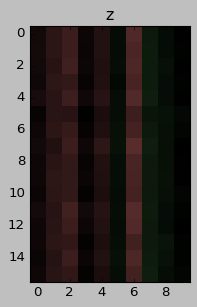

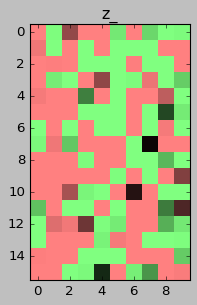

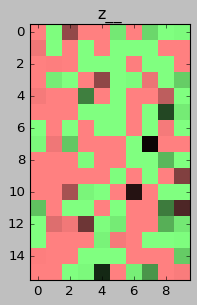

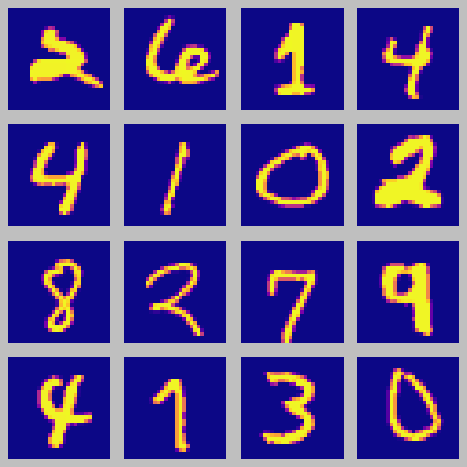

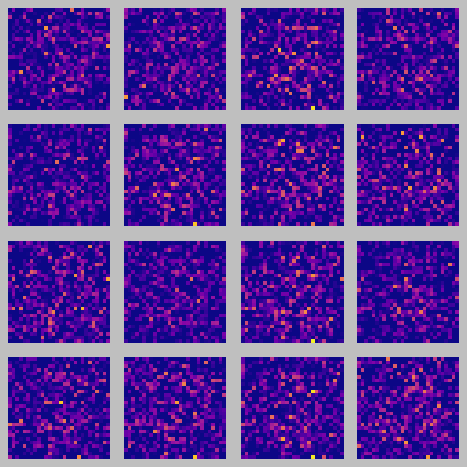

Epoch: 100 	 Loss: 0.066367


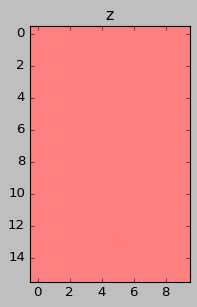

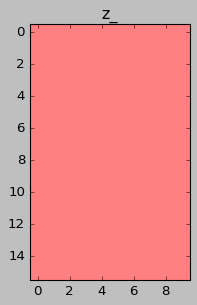

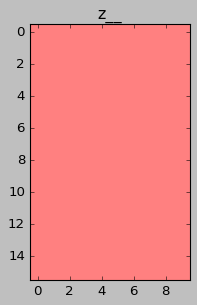

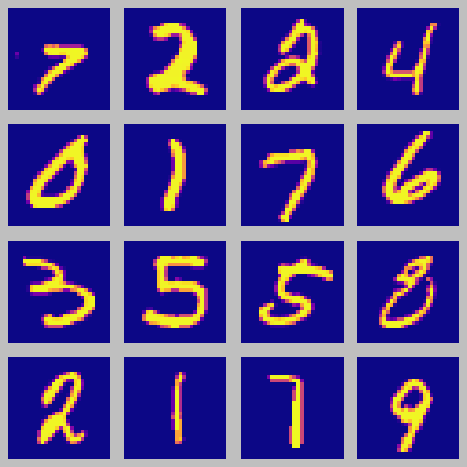

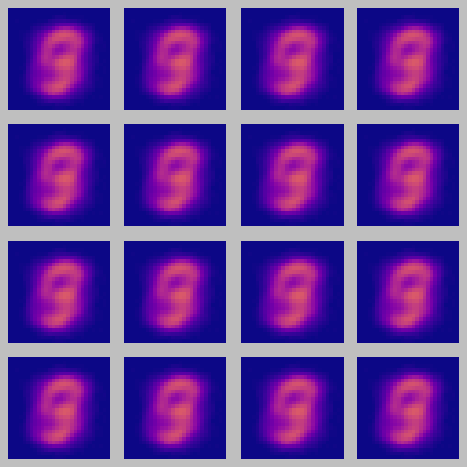

Epoch: 200 	 Loss: 0.071421


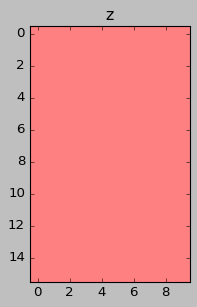

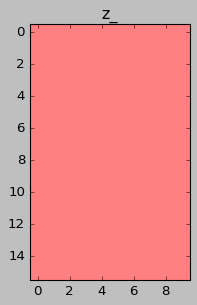

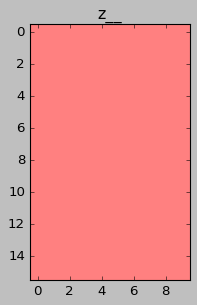

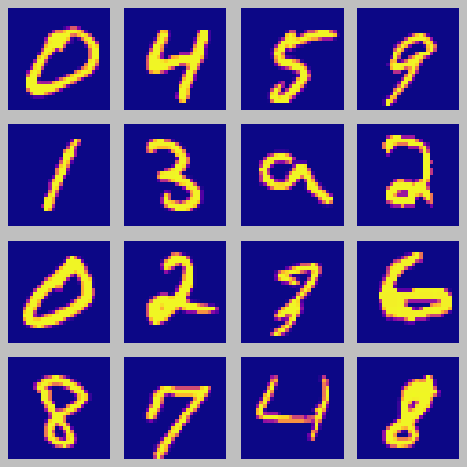

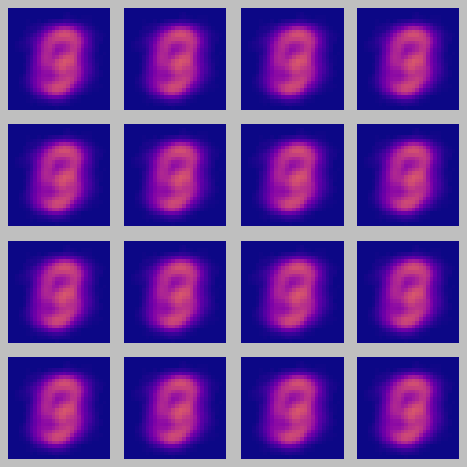

Epoch: 300 	 Loss: 0.065184


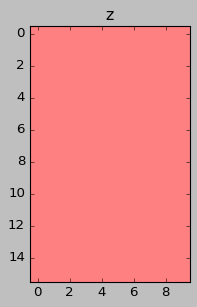

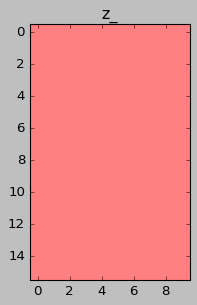

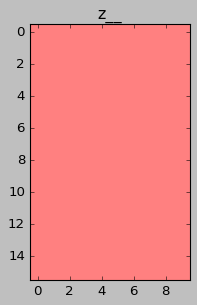

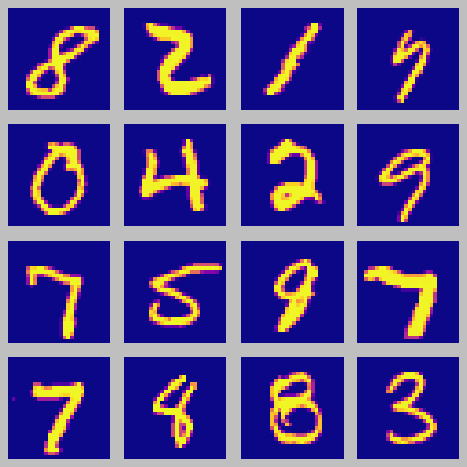

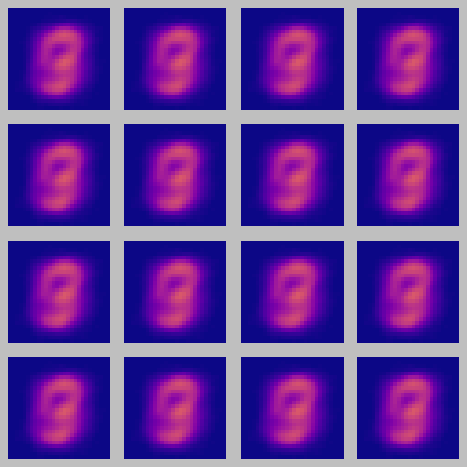

Epoch: 400 	 Loss: 0.063927


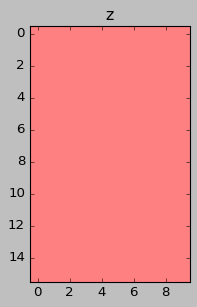

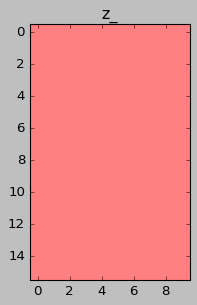

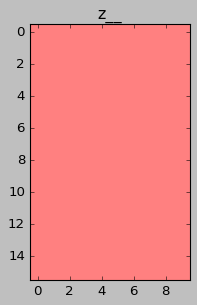

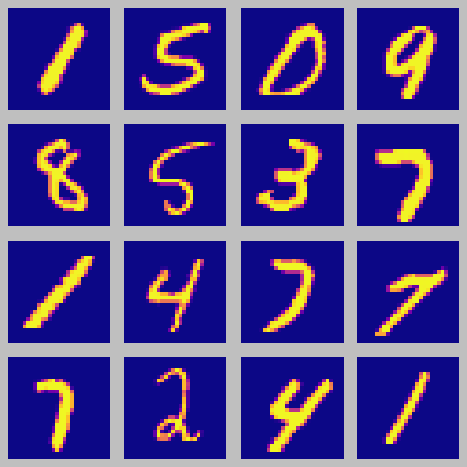

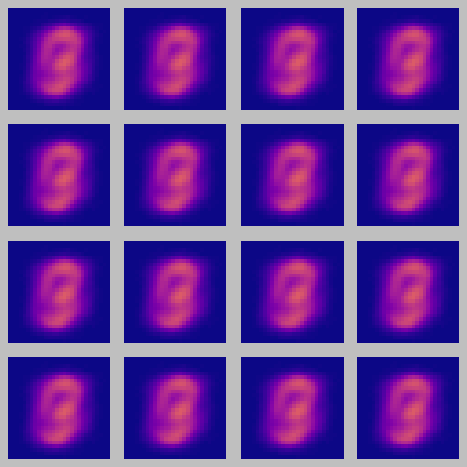

Epoch: 500 	 Loss: 0.063630


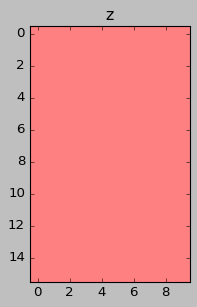

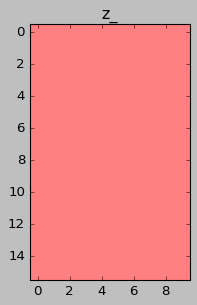

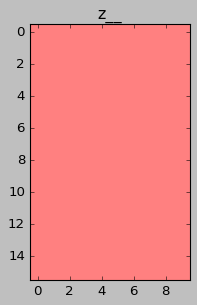

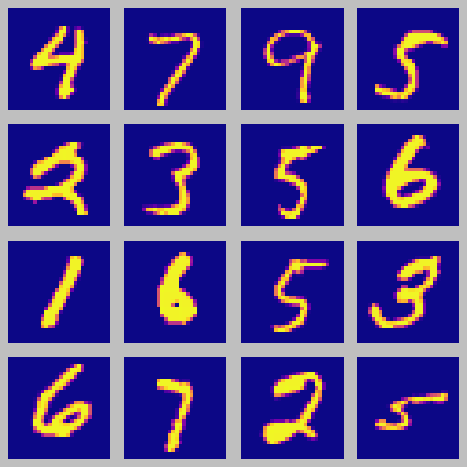

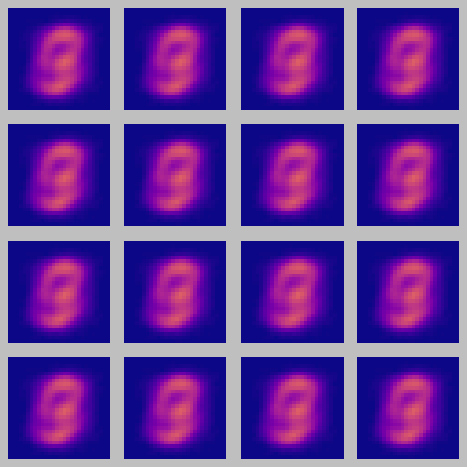

Epoch: 600 	 Loss: 0.071331


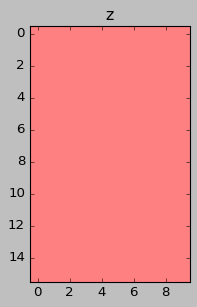

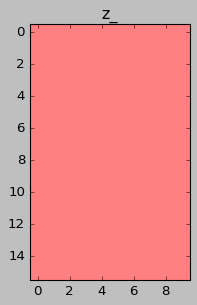

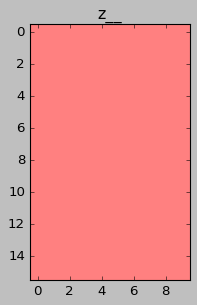

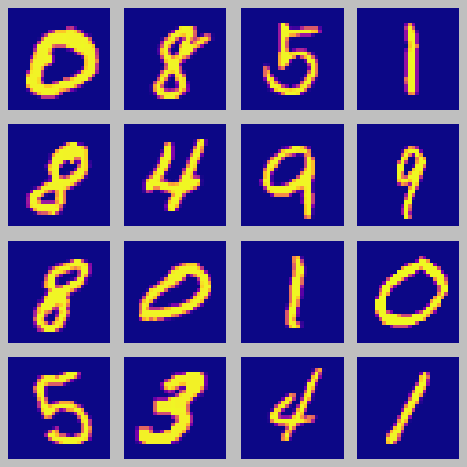

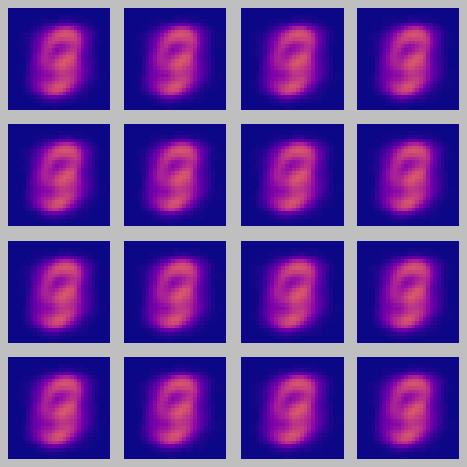

Epoch: 700 	 Loss: 0.065421


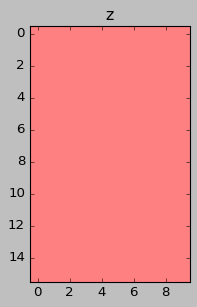

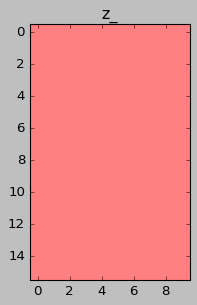

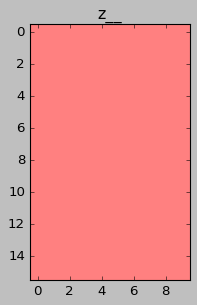

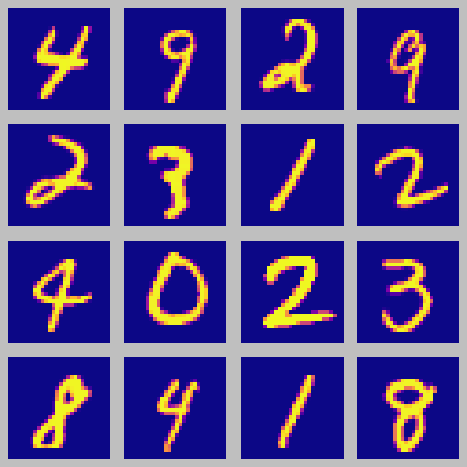

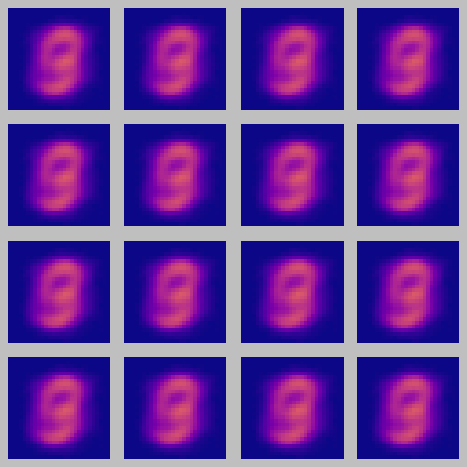

Epoch: 800 	 Loss: 0.068285


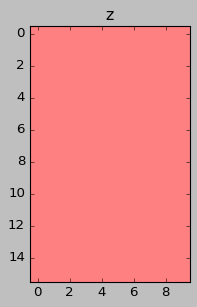

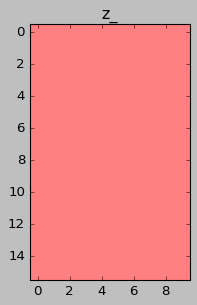

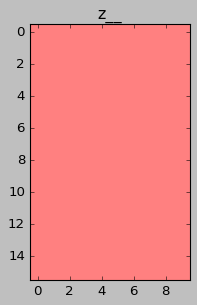

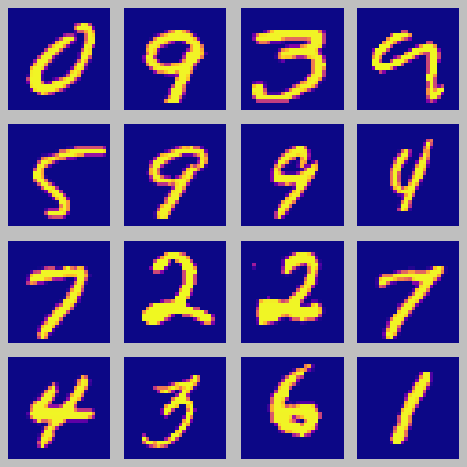

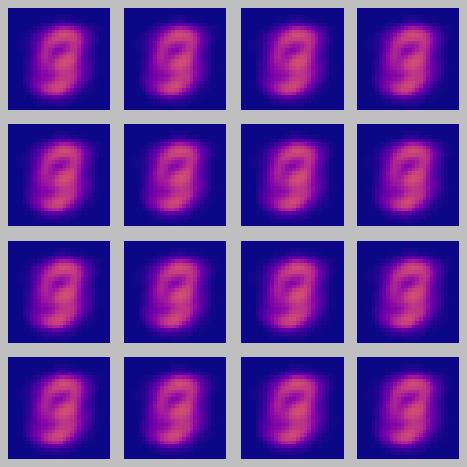

Epoch: 900 	 Loss: 0.067806


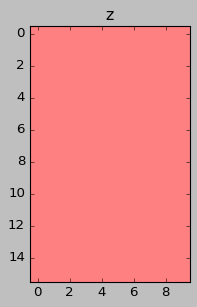

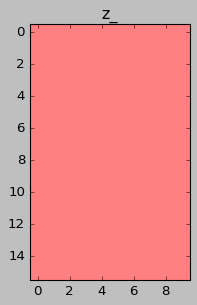

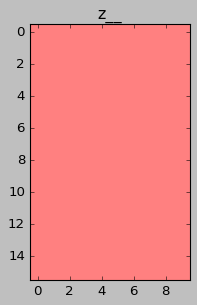

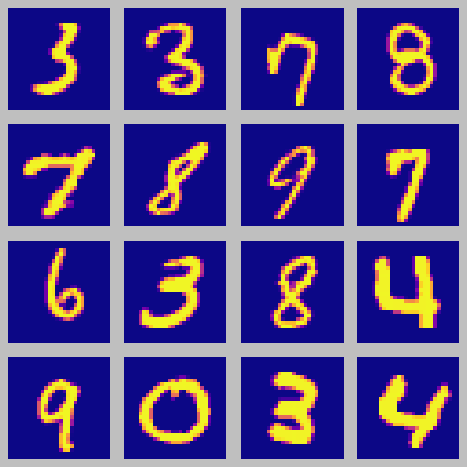

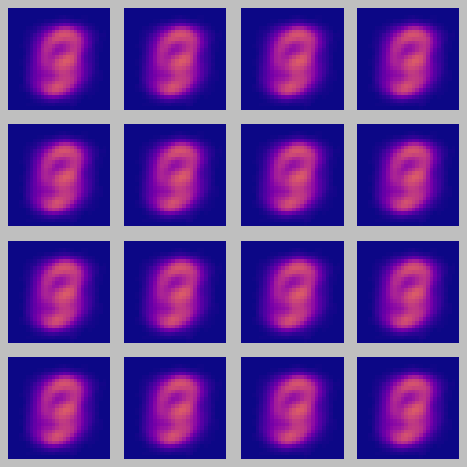

In [38]:
resolution = 10

data = load_mnist()
#X = next(iter())[0].squeeze(dim=1).view(1000, -1).float()

model = QDAE(input_output_size=28*28, hidden_size=resolution * 3, latent_feature_count=1, resolution=resolution)

#for param in model.parameters():
    # print(type(param.data), param.size())
    #nn.init.constant(param.data, val=0.1)
    #param.data += 0.1
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train(model=model, device=device, data=data, optimizer=optimizer, epochs=1000, log_interval=100)

In [5]:
show_image_grid(X[0:16].view(-1,28,28), nrows=4, ncols=4, fig_width=6)
z, z_, z__, X_bar = model(X[0:16])
show_image_grid(X_bar.view(-1,28,28), nrows=4, ncols=4, fig_width=6)

NameError: ignored

In [0]:
# latent vector arithmatic
show_image(qd_h.detach(), print_values=False)
qd = (qd_h[7] + qd_h[8]) / 2
qd = qd.unsqueeze(dim=0)
show_image(qd_h[7].unsqueeze(dim=0).detach(), print_values=True)
show_image(qd_h[8].unsqueeze(dim=0).detach(), print_values=True)

show_image(qd_h[0].unsqueeze(dim=0).detach(), print_values=True)
show_image(qd.detach(), print_values=True)
y_bar = model.decode(qd_h[0])
show_image(y_bar.view(3,3).detach())


In [0]:
dr = 5
c = 5
mu = torch.tensor(np.linspace(0, 1, r * c)).unsqueeze(0).unsqueeze(0).unsqueeze(0).float()
var = torch.ones(mu.shape).float() * 0.2

y = to_pdf(mu, var, resolution=resolution).squeeze().float()
print(y.shape)
show_image(y)
y_bar = model.decode(y)
print("y_bar", y_bar.shape)
show_image_grid(y_bar.view(-1,3,3), nrows=r, ncols=c, fig_width=3)